# A simple deterministic example #

This Notebook provides an easy way to run a simple deterministic simulation (i.e. all probabilities are 1 or 0, so events either always or never happen). 



We start by loading the households package:

In [1]:
import os
os.chdir('..')
from households import *
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
#This is not needed, but is here as an example
#import sys
#sys.path.append('C:\\\\github\\\\Dummy-Classes')
#import practice_class_functions

Importing the households package
Importing identity
importing kinship
importing residency
importing behavior
loading narrative
Importing main.py
importing inheritance
importing marriage
importing mobility


(You'll only ever need to run this next line if you've made changes to the code and are needing to reload the package.)

In [2]:
from households import *

## Scheduling life events ##
In this world everyone gets married at age 20, has up to four children, and dies at age 60. To accomplish this, we define AgeTables for eligibility (starting at an age of majority such that everyone achieves eligibility at 19 to be married at age 20 if sufficient partners exist), fertility (four years max of potential fertility when married), and mortality (univerally 1 starting at age 60, ensuring everyone dies then), with remarriage defined by an all-zero table.

In [3]:
age_of_majority = 19
eligibility = AgeTable(ages = [0,age_of_majority,100], sex1 = female, rates1 = [0,.5], sex2 = male, rates2 = [0,.25])
fertility = AgeTable(ages = [0,age_of_majority,age_of_majority+10,100], sex1 = female, rates1 = [0,.65,0], sex2 = male, rates2 = [0,0,0])
mortality = AgeTable(ages=[0,5,20,50,70,100], sex1 = male, rates1 = [.1,.01,0,.05,.5], sex2 = female, rates2 = [.1,.01,0,.05,.5])
remarriage = AgeTable(ages = [0,age_of_majority,100], sex1 = female, rates1 = [0,.1], sex2 = male, rates2 = [0,.1])


All of these AgeTables need to be inserted into the appropriate syntax: in the case of mortality and fertility rates, these are still given directly to the starting community of `Persons`, while eligibility and remarriage are actually part of a `MarriageRule` that gets passed from the community to individual people.

The three rules that we have to define are, at present, a `MarriageRule`, a `MobilityRule`, and an `InheritanceRule`. We treat these each in turn.


### `MarriageRule`: Pick a random, single, eligible spouse

The `MarriageRule` we will implement will use the `eligibility` and `remarriage` schedules above and then define what is involved in finding and marrying a spouse via the defined functions in `behavior.marriage`. In particular, we need to define:

    1. who is considered a potential spouse,
    2. how we will pick among the selection of spouses, and 
    3. where newlyweds live

We define an eligible partner as any single, eligible (`unmarried`), non-sibling in the same community using `get_eligible_not_sibling_same_community`. We pick a spouse at random from the selection (`pick_spouse_random`) and then attempt to move the new couple in with the husband's family if there is space; otherwise they move to a new house (`locality_patrilocality`).

### `MobilityRule`: Adult children leave a household with their nuclear family if it gets overcrowded

The `MobilityRule` we will create will check whether an adult is living in an overcrowded house they don't own, and then move them with their spouse and children to a new house. There exists a default function to check whether a household is overcrowded (`check_household_overcrowded`), but we need to create a new function that combines this with the age check and the ownership check. We will call this function `check_household_nonowner_adult_man_overcrowded` to keep the nomenclature consistent. We then use the existing `who_leaves_house_family` to identify their family and `destination_random_house_same_village` to find a new house to move them to.

### `InheritanceRule`: Let sons and then brothers' sons inherit houses, but only own one

The `InheritanceRule` will be to check the male line of a family, starting with male children and followed by brothers' sons. We implement this by using the `find_heirs_multiple_constructor`, which combines multiple `find_heirs` functions into a single ordered list. We call this new function `find_heirs_sons_then_brothers_sons` and use it to defined the heirs of a person with a house to be inherited (`has_property_houses`). We then limit all heirs to lack property before inheritance (`limit_heirs_not_owners`), and say that the first heir in the list (who is therefore likely the oldest son or oldest brother's older son without a house) will be the one to inherit (`distribute_property_to_first_heir_and_move_household`). If inheritance fails, the house defaults to no owner, and once all family members leave or die it will default to no ownership (`failed_inheritance_no_owner`). 

### `BirthRule`: Use the fertility schedule without infanticide or maternal death

Using the AgeTable for fertiltiy above, the `BirthRule` just passes this as the fertility for a married woman, with fertility for an unmarried woman defined as a NullAgeTable (always 0). The sex ratio is 50-50, and neither infanticide nor maternal death during childbirth are chosen as options.

In [4]:
#The MarriageRule
marriagerule = behavior.marriage.MarriageRule(eligibility_agetable = eligibility, #defined above
                                              get_eligible = behavior.marriage.get_eligible_not_sibling_same_community,
                                              #find all single individuals in the village who aren't siblings
                                              pick_spouse = behavior.marriage.pick_spouse_random, #pick a random spouse
                                              locality = behavior.marriage.locality_patrilocality, #patrilocality
                                              remarriage_agetable = remarriage #defined above
                                             )

#The MobilityRule
def check_household_nonowner_adult_man_overcrowded(person):
    """Check that the household is overcrowded and that this person is not the owner and an adult."""
    overcrowded = behavior.mobility.check_household_overcrowded(person) #check overcrowding but also assert
    ## that there is indeed a house to check
    if overcrowded:
        if person.age >= age_of_majority and person not in person.has_house.get_owners() and person.sex == identity.male:
            #If above or at the age of majority and the person is a man who is not the owner of the house they live in
            return True
    return False

mobilityrule = behavior.mobility.MobilityRule(check_household = check_household_nonowner_adult_man_overcrowded,
                                                   who_leaves_house = behavior.mobility.who_leaves_house_family,
                                                   destination = behavior.mobility.destination_random_house_same_village)

#The InheritanceRule
#Our custom function to check sons then brothers' sons;
## note the use of lambda to make find_heirs_siblings_children into a single parameter function in order to define
## the sex as male.
find_heirs_sons_then_brothers_sons = behavior.inheritance.find_heirs_multiple_constructor(behavior.inheritance.find_heirs_sons_oldest_to_youngest,
                                                     lambda p: behavior.inheritance.find_heirs_siblings_children_oldest_to_youngest(p,sex = identity.male))


inheritancerule = behavior.inheritance.InheritanceRuleComplex(has_property = behavior.inheritance.has_property_houses,
                                                                    find_heirs = find_heirs_sons_then_brothers_sons,
                                                                    limit_heirs = behavior.inheritance.limit_heirs_not_owners,
                                                                    distribute_property = behavior.inheritance.distribute_property_to_first_heir_and_move_household,
                                                                    failure = behavior.inheritance.failed_inheritance_no_owner)

birthrule = behavior.conception.BirthRule(marriedbirth = fertility,
                                         unmarriedbirth = AgeTable.NullAgeTable(),
                                         femalesexratio = .5,
                                         maternaldeath = behavior.conception.maternal_death_zero,
                                         infanticide = behavior.conception.infanticide_none)

With all of these functions defined, we can now create the `World` of the simulation and our sole `Community`, Sweetwater.

In [5]:
start_pop = 100 #just a few people to start
start_area = 200 #lots of room for growth
start_age = age_of_majority - 1 #so that everyone makes the transition to marriage eligibility on time

rd.seed(1237) #Used here to standardize the example code across runs for any random parts like name generation.
terra = World()
sweetwater = Community(world = terra,
                       name = 'Sweetwater',
                       pop = start_pop,
                       area = start_area,
                       startage = start_age,
                       mortab = mortality,
                       birthtab = fertility,
                       marriagerule = marriagerule,
                       inheritancerule = inheritancerule,
                       mobilityrule = mobilityrule,
                       birthrule = birthrule)


rd.seed(1237) #important to standardize after setup, just in case
pophistory = []

And there we have it! The hard work is setting up the functions; making the world and defining communities is easy. We can now run the simulation.

In [6]:
while terra.year < 43: #run for 42 years
    terra.progress()
    pophistory.append(len(terra.people))
    
print(terra.year)

43


We can now generate some figures to see what's been going on. For instance, let's see what birthyears are recorded in Diaries of individuals.

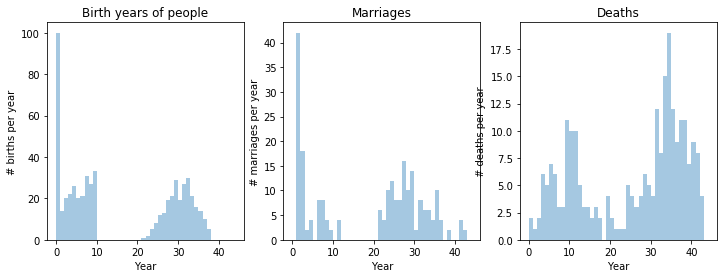

In [7]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))
#sns.set_style("whitegrid")
sns.distplot([min(d.get_events().keys()) for d in terra.library['Person']], kde = False, bins = range(45), ax = ax1)
ax1.set_title("Birth years of people")
#plt.subtitle("Third generation is normally distributed.")
ax1.set_xlabel("Year")
ax1.set_ylabel("# births per year")

sns.distplot([l.year for i in range(len(terra.library['Person'])) for x in terra.library['Person'][i].get_events().items() for l in x[1] if isinstance(l,narrative.MarriageEvent)]
             , kde = False, bins = range(45), ax = ax2)
ax2.set_title("Marriages")
#ax2.subtitle("Third generation is normally distributed.")
ax2.set_xlabel("Year")
ax2.set_ylabel("# marriages per year")

sns.distplot([l.year for i in range(len(terra.library['Person'])) for x in terra.library['Person'][i].get_events().items() for l in x[1] if isinstance(l,narrative.DeathEvent)],
             kde = False, bins = range(45), ax = ax3)
ax3.set_title("Deaths")
#ax2.subtitle("Third generation is normally distributed.")
ax3.set_xlabel("Year")
ax3.set_ylabel("# deaths per year")


print('')
#plt.hist([min(d.get_events().keys()) for d in terra.library['Person']], bins = range(45))

We can also look at the different ways people are living in houses, for example how many nuclear families live in each house.

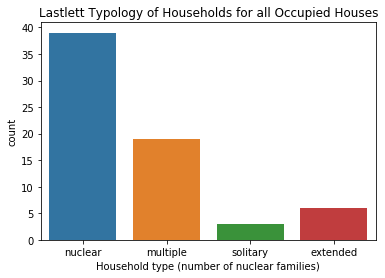

In [8]:
sns.countplot([residency.classify(h) for h in terra.houses if h.people != []])
plt.title('Lastlett Typology of Households for all Occupied Houses')
plt.xlabel('Household type (number of nuclear families)')
print('')

Text(0.5, 1.0, 'Population through time')

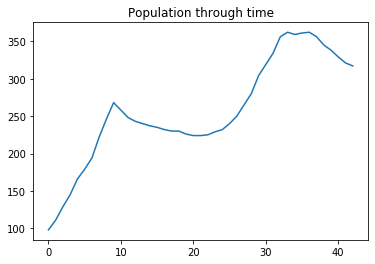

In [9]:
sns.lineplot(range(terra.year),pophistory)
plt.title('Population through time')

In addition to viewing the entire world, we can also use the tools in narrative to explore single individuals and their households.

In [10]:
h = rd.choice([x for x in sweetwater.houses if len(x.people) >= 2])#pick a house with at least two people in it to make it interesting
print('The house at ' + h.address + ' contains ' + narrative.census(h)+':')
for x in h.people:
    print(narrative.biography(x)) 
print(' ')




The house at 21 Tavern Trail contains a nuclear household with 4 people residing owned by Hector (1.0 shares):
Hector is a living man, 35 years old, married with 4 children
Emily is a living woman, 39 years old, married with 4 children
Elsie is a living woman, 13 years old, ineligible
Elsie is a living woman, 12 years old, ineligible
 


In [11]:
#Here is some space to explore the currently selected household, if you want.

print(narrative.biography(h.people[0]))

Hector is a living man, 35 years old, married with 4 children


This provides the tools you need to implement and see some results of a simulation. 

The sections below provide some debugging tools.

In [12]:
#Look up a single person based on memory
p = [p for p in sweetwater.people if str(p) == '<households.main.Person object at 0x00000244063379C8>'][0]
#behavior.mobility.check_household_overcrowded(p)
#behavior.mobility.destination_random_house_same_village(None, [p])
narrative.biography(p)
narrative.census(p.has_house)
for q in kinship.get_parents(p):
    print(narrative.biography(q))
    if q.has_house != None: print(narrative.census(q.has_house))

IndexError: list index out of range